In [ ]:
from osgeo import gdal
from __future__ import print_function
import glob
import glob2
gdal.UseExceptions()
import tensorflow as tf
from tensorflow.keras.models import load_model

In [ ]:
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Reshape, Activation, Permute, Lambda, Concatenate,GlobalAveragePooling2D
from keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model

from __future__ import print_function
import os
import sys
import time
import logging
import numpy as np
import tensorflow as tf


In [ ]:
Staten_island_test = np.load('/content/drive/MyDrive/ADS_ML_Spring_2022/ADS/Data/Final_Test/Staten_island_test.npy')

In [ ]:
Staten_island_test.shape

(223725, 32, 32, 10)

In [ ]:
model = load_model("/content/drive/MyDrive/ADS_ML_Spring_2022/ADS/model/so2_sat_satellite-classification.h5")

In [ ]:
classes_x=model.predict(Staten_island_test,batch_size=256) 

In [ ]:
del Staten_island_test

In [ ]:
classes_x

array([[2.1903933e-04, 4.3171854e-05, 6.9984948e-05, ..., 8.5722989e-01,
        9.5325317e-03, 2.3001604e-04],
       [2.1903933e-04, 4.3171854e-05, 6.9984948e-05, ..., 8.5722989e-01,
        9.5325317e-03, 2.3001604e-04],
       [2.1903933e-04, 4.3171854e-05, 6.9984948e-05, ..., 8.5722989e-01,
        9.5325317e-03, 2.3001604e-04],
       ...,
       [2.5131911e-04, 5.3251999e-05, 8.9711153e-05, ..., 8.4918839e-01,
        1.0869641e-02, 2.6848144e-04],
       [2.1903933e-04, 4.3171938e-05, 6.9984948e-05, ..., 8.5722989e-01,
        9.5325364e-03, 2.3001649e-04],
       [2.1903933e-04, 4.3171938e-05, 6.9984948e-05, ..., 8.5722989e-01,
        9.5325364e-03, 2.3001646e-04]], dtype=float32)

In [ ]:
Staten_Island_Y = np.argmax(classes_x,axis=-1)

In [ ]:
Staten_Island_Y.shape

(223725,)

In [ ]:
Staten_Island_Y_grid = np.reshape(Staten_Island_Y, (471, 475))

In [ ]:
Staten_Island_Y_grid.shape


(471, 475)

In [ ]:
np.save('/content/drive/MyDrive/ADS_ML_Spring_2022/ADS/Data/Final_Test/Staten_Island_Y', Staten_Island_Y)


In [ ]:
Manhattan_test = np.load('/content/drive/MyDrive/ADS_ML_Spring_2022/ADS/Data/Final_Test/Manhattan_test.npy')

In [ ]:
Manhattan_test.shape

(223725, 32, 32, 10)

In [ ]:
classes_x=model.predict(Manhattan_test)

In [ ]:
Manhattan_Y = np.argmax(classes_x,axis=-1)

In [ ]:
np.save('/content/drive/MyDrive/ADS_ML_Spring_2022/ADS/Data/Final_Test/Manhattan_Y', Manhattan_Y)

In [ ]:
# loading Staten Island predictions

Staten_Island_Y = np.load('/content/drive/MyDrive/ADS_ML_Spring_2022/ADS/Data/Final_Test/Staten_Island_Y.npy')

In [ ]:
Staten_Island_Y.shape

(223725,)

In [ ]:
Manhattan_Y = np.load('/content/drive/MyDrive/ADS_ML_Spring_2022/ADS/Data/Final_Test/Manhattan_Y.npy')

In [ ]:
Manhattan_Y.shape

(223725,)

In [ ]:
Manhattan_Y_grid = np.reshape(Manhattan_Y, (471, 475))


In [ ]:


from __future__ import print_function
import os
import glob
import numpy as np
from osgeo import gdal
import sys
gdal.UseExceptions()

def saveProbabilityPrediction(probPred,tiffPath):
# this function save the predicted probabilities
    try:
        fid = gdal.Open(tiffPath)
    except RuntimeError as e:
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        print("ERROR:           the given data geotiff can not be open by GDAL")
        print("DIRECTORY:       "+tiffPath)
        print("GDAL EXCEPCTION: "+e)
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        sys.exit(1)

    row = fid.RasterYSize
    col = fid.RasterXSize
    bnd = fid.RasterCount
    proj = fid.GetProjection()
    geoInfo = fid.GetGeoTransform()
    del(fid)

    if probPred.shape[0] != row * col:
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        print("ERROR:           number of patches does not suit the output size")
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        sys.exit(1)

    #print(np.median(probPred[:]))
    probPred = np.array(probPred*1e4)
    #print(np.median(probPred[:]))
    probPred = probPred.astype(np.int16)
    #print(np.median(probPred[:]))
    #print(probPred.shape)
    prob = np.transpose(np.reshape(probPred,(row,col,17)),(2,0,1))
    #print(probPred.shape)


    LCZDriver = gdal.GetDriverByName('GTiff')
    LCZFile = LCZDriver.Create(tiffPath, col, row, bnd, gdal.GDT_UInt16)
    LCZFile.SetProjection(proj)
    LCZFile.SetGeoTransform(geoInfo)

    # save file with int zeros
    idBnd = np.arange(0,bnd,dtype=int)
    for idxBnd in idBnd:
        outBand = LCZFile.GetRasterBand(int(idxBnd+1))
        outBand.WriteArray(prob[idxBnd,:,:].astype(np.int16))
        outBand.FlushCache()
        del(outBand)

    return tiffPath




def saveLabelPrediction(labPred,tiffPath):
# this function save the predicted label
    try:
        fid = gdal.Open(tiffPath)
    except RuntimeError as e:
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        print("ERROR:           the given data geotiff can not be open by GDAL")
        print("DIRECTORY:       "+tiffPath)
        print("GDAL EXCEPCTION: "+e)
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        sys.exit(1)

    row = fid.RasterYSize
    col = fid.RasterXSize
    bnd = fid.RasterCount
    proj = fid.GetProjection()
    geoInfo = fid.GetGeoTransform()
    del(fid)

    if labPred.shape[0] != row * col:
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        print("ERROR:           number of patches does not suit the output size")
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        sys.exit(1)

    print(labPred.shape)
    print(np.median(labPred[:]))
    lab = np.reshape(labPred,(row,col))+1
#    lab = prob.argmax(axis=2).astype(np.uint8)+1
    print(lab.shape)
    print(np.median(lab[:]))


    LCZDriver = gdal.GetDriverByName('GTiff')
    LCZFile = LCZDriver.Create(tiffPath, col, row, bnd, gdal.GDT_UInt16)
    LCZFile.SetProjection(proj)
    LCZFile.SetGeoTransform(geoInfo)

    # save file with predicted label
    outBand = LCZFile.GetRasterBand(1)
    outBand.WriteArray(lab)
    outBand.FlushCache()
    del(outBand)

    return tiffPath





def getPatch(data,imageCoord,patchsize):
# this function gets data patch with give image coordinate and patch size
    halfPatchSize = np.int(np.floor(patchsize/2))

    outData = np.lib.pad(data,((0,0),(halfPatchSize,halfPatchSize),(halfPatchSize,halfPatchSize)),'symmetric')
    outData = np.transpose(outData,(1,2,0))

    imageCoord = imageCoord + halfPatchSize

    print('INFO:    Array size: ' + str(imageCoord.shape[0]) + ',' + str(patchsize) + ',' + str(patchsize) + ',' + str(data.shape[0]))
    dataPatch = np.zeros((imageCoord.shape[0], patchsize,patchsize,data.shape[0]), dtype=np.float32)

    for i in range(0,imageCoord.shape[0]):
        #print(i)
        dataPatch[i,:,:,:] = outData[imageCoord[i,1]-halfPatchSize:imageCoord[i,1]+halfPatchSize,imageCoord[i,0]-halfPatchSize:imageCoord[i,0]+halfPatchSize,:]

    return dataPatch



def getImageCoordByXYCoord(coord,path2Data):
# this function gets data patches by given coordinates
# Input:
#         - coord           -- coordinate [x,y]
#         - path2Data       -- path to unfiltered tiff data
#
# Output:
#         - imageCoord      -- image coordinate of the input real world coordiate
#


    try:
        fid = gdal.Open(path2Data)
    except RuntimeError as e:
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        print("ERROR:           the given ground truth geotiff can not be open by GDAL")
        print("DIRECTORY:       "+gtPath)
        print("GDAL EXCEPCTION: "+e)
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        sys.exit(1)


    geoInfoData = fid.GetGeoTransform()

    imageCoord = np.zeros(coord.shape)

    imageCoord[:,0] = np.round((coord[:,0] - geoInfoData[0])/geoInfoData[1])
    imageCoord[:,1] = np.round((geoInfoData[3] - coord[:,1])/np.abs(geoInfoData[5]))

    return imageCoord.astype(int)


def getCoordLCZGrid(lczPath):
# this function gets the coordinate of every cell for the LCZ classification map
# Input:
#         - lczPath         -- path to a initialed lcz classification map grid
#
# Output:
#         - coordCell       -- the coordinate of each cell of the map grid. A N by 2 array with N is the number of cell, 1st col is x-coordinate, 2nd col is y-coordinate, The coordinate organized line by line.
#

    try:
        fid = gdal.Open(lczPath)
    except RuntimeError as e:
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        print("ERROR:           the given ground truth geotiff can not be open by GDAL")
        print("DIRECTORY:       "+gtPath)
        print("GDAL EXCEPCTION: "+e)
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        sys.exit(1)

    # read the grid and find coordinate of each cell
    row_cell = np.arange(0,fid.RasterYSize)
    col_cell = np.arange(0,fid.RasterXSize)

    geoInfoGrid = fid.GetGeoTransform()

    xWorld = geoInfoGrid[0] + col_cell * geoInfoGrid[1];
    yWorld = geoInfoGrid[3] + row_cell * geoInfoGrid[5];

    [xWorld,yWorld] = np.meshgrid(xWorld,yWorld)
    coordCell = np.transpose(np.stack((np.ravel(xWorld),np.ravel(yWorld)),axis=0))
    return coordCell






def initialLCZGrids(tiffData):
# this function initial a LCZ label grid and a LCZ probability grid.
#    Input:
#        - tiffData        -- path to sentinel-1 tiff data
#                          -- EXAMPLE: tiffData = '/data/hu/global_processing/01692_22142_Katowice/geocoded_subset_unfilt_dat/201706/S1B_IW_SLC__1SDV_20170601T045205_20170601T045232_005852_00A42A_504B_Orb_Cal_Deb_TC_SUB.tif'
#
#    Output:
#        - return 0        -- a LCZ tiff initialized
#                          -- EXAMPLE:
#
    # number of bands, number of LCZ classes
    nbBnd = 12

    # read geoinformation from the sentinel-1 tiff data
    dataFile = gdal.Open(tiffData)
    dataCoordSys = np.array(dataFile.GetGeoTransform())
    dataCol = dataFile.RasterXSize
    dataRow = dataFile.RasterYSize

    # set geoinformation for the output LCZ label grid
    # set resolution and coordinate for upper-left point
    LCZCoordSys = dataCoordSys.copy()
    LCZCoordSys[1] = 100
    LCZCoordSys[5] = -100
    LCZCol = np.arange(dataCoordSys[0],dataCoordSys[0]+dataCol*dataCoordSys[1],LCZCoordSys[1]).shape[0]
    LCZRow = np.arange(dataCoordSys[3],dataCoordSys[3]+dataRow*dataCoordSys[5],LCZCoordSys[5]).shape[0]

    # set the directory of initial grid
    savePath = '/'.join(tiffData.split('/')[:-1])
    savePath = savePath.replace(tiffData.split('/')[-3],'LCZClaMap')
    if not os.path.exists(savePath):
        os.makedirs(savePath)

    # initial the grid and set resolution, projection, and coordinate
    LCZDriver = gdal.GetDriverByName('GTiff')
    LCZTiffPath = savePath+'/LCZLabel.tif'
    LCZFile = LCZDriver.Create(savePath+'/LCZLabel.tif', LCZCol, LCZRow)
    LCZFile.SetProjection(dataFile.GetProjection())
    LCZFile.SetGeoTransform(LCZCoordSys)

    # save file with int zeros
    LCZLabel = np.zeros((LCZRow,LCZCol),dtype = int)
    outBand = LCZFile.GetRasterBand(1)
    outBand.WriteArray(LCZLabel)
    outBand.FlushCache()

    del(LCZDriver)
    del(LCZFile)
    del(outBand)
    del(LCZLabel)


    # initial the grid and set resolution, projection, and coordinate
    LCZDriver = gdal.GetDriverByName('GTiff')
    LCZFile = LCZDriver.Create(savePath+'/LCZProb.tif', LCZCol, LCZRow, nbBnd)
    LCZFile.SetProjection(dataFile.GetProjection())
    LCZFile.SetGeoTransform(LCZCoordSys)

    # save file with int zeros
    LCZLabel = np.zeros((LCZRow,LCZCol))
    idBnd = np.arange(0,nbBnd,dtype=int)
    for idxBnd in idBnd:
        outBand = LCZFile.GetRasterBand(idxBnd+1)
        outBand.WriteArray(LCZLabel)
        outBand.FlushCache()
        del(outBand)
    outputpath = [savePath+'/LCZLabel.tif',savePath+'/LCZProb.tif']

    return outputpath





def initialLCZLabelGrid(tiffData,outGridDir):
# this function initial a 100 meter resolution LCZ label grid based on input geotiff.
#    Input:
#        - tiffData        -- path to sentinel-1 or senitnel-2 tiff data
# 	 - outGridDir      -- path to initialed lcz label geotiff
#
#    Output:
#        - return 0        -- a LCZ tiff initialized
    # read geoinformation from the sentinel-1 tiff data
    dataFile = gdal.Open(tiffData)
    dataCoordSys = np.array(dataFile.GetGeoTransform())
    dataCol = dataFile.RasterXSize
    dataRow = dataFile.RasterYSize

    # set geoinformation for the output LCZ label grid
    # set resolution and coordinate for upper-left point
    LCZCoordSys = dataCoordSys.copy()
    LCZCoordSys[1] = 100
    LCZCoordSys[5] = -100
    LCZCol = np.arange(dataCoordSys[0],dataCoordSys[0]+dataCol*dataCoordSys[1],LCZCoordSys[1]).shape[0]
    LCZRow = np.arange(dataCoordSys[3],dataCoordSys[3]+dataRow*dataCoordSys[5],LCZCoordSys[5]).shape[0]

    # set the directory of initial grid
    savePath = '/'.join(outGridDir.split('/')[:-1])
    if not os.path.exists(savePath):
        os.makedirs(savePath)

    # initial the grid and set resolution, projection, and coordinate
    LCZDriver = gdal.GetDriverByName('GTiff')
    LCZFile = LCZDriver.Create(outGridDir, LCZCol, LCZRow)
    LCZFile.SetProjection(dataFile.GetProjection())
    LCZFile.SetGeoTransform(LCZCoordSys)

    # save file with int zeros
    LCZLabel = np.zeros((LCZRow,LCZCol),dtype = np.int8)
    outBand = LCZFile.GetRasterBand(1)
    outBand.WriteArray(LCZLabel)
    outBand.FlushCache()
    return 0

def initialLCZProbGrid(tiffData,outGridDir):
# this function initial a 100 meter resolution LCZ label grid based on input geotiff.
#    Input:
#        - tiffData        -- path to sentinel-1 or sentinel-2 tiff data
# 	 - outGridDir      -- path to initialized softmax geotiff file
#
#    Output:
#        - return 0        -- a LCZ tiff initialized with 17 bands, each of them presents a probability that the pixel falls under a class
#                          -- EXAMPLE:
#
    # number of bands, number of LCZ classes
    nbBnd = 17
    # read geoinformation from the sentinel-1 tiff data
    dataFile = gdal.Open(tiffData)
    dataCoordSys = np.array(dataFile.GetGeoTransform())
    dataCol = dataFile.RasterXSize
    dataRow = dataFile.RasterYSize

    # set geoinformation for the output LCZ label grid
    # set resolution and coordinate for upper-left point
    LCZCoordSys = dataCoordSys.copy()
    LCZCoordSys[1] = 100
    LCZCoordSys[5] = -100
    LCZCol = np.arange(dataCoordSys[0],dataCoordSys[0]+dataCol*dataCoordSys[1],LCZCoordSys[1]).shape[0]
    LCZRow = np.arange(dataCoordSys[3],dataCoordSys[3]+dataRow*dataCoordSys[5],LCZCoordSys[5]).shape[0]

    # set the directory of initial grid
    savePath = '/'.join(outGridDir.split('/')[:-1])
    if not os.path.exists(savePath):
        os.makedirs(savePath)

    # initial the grid and set resolution, projection, and coordinate
    LCZDriver = gdal.GetDriverByName('GTiff')
    LCZFile = LCZDriver.Create(outGridDir, LCZCol, LCZRow, nbBnd)
    LCZFile.SetProjection(dataFile.GetProjection())
    LCZFile.SetGeoTransform(LCZCoordSys)

    # save file with int zeros
    LCZProb = np.zeros((LCZRow,LCZCol),dtype = np.int16)
    nbBnd = 11
    idBnd = np.arange(0,nbBnd,dtype=int)
    for idxBnd in idBnd:
        outBand = LCZFile.GetRasterBand(int(idxBnd+1))
        outBand.WriteArray(LCZProb)
        outBand.FlushCache()
        del(outBand)

    return 0

In [ ]:
city = "manhattan"
path2DataOfCity = sys.argv[1]
dataPathTif = "/content/drive/MyDrive/ADS_ML_Spring_2022/ADS/Data/Final_Test/manhaattan1.tif"

In [ ]:
outProbTif = path2DataOfCity+'/LCZ_ResNet20/'+city+dataPathTif[dataPathTif.rfind('_'):-4]+'_pro.tiff'
outLabelTif = outProbTif.replace('_pro','_lab')
print('INFO:    The classification map: {}'.format(outLabelTif))
#print(outProbTif)
#print(outLabelTif)

# initial classification map tiff file
LCZProbPath = initialLCZProbGrid(dataPathTif,outProbTif)

# LCZLabelPath = gp.initialLCZLabelGrid(dataPathTif,outLabelTif)

  #file name of the mv results
outLabelTif_mv = path2DataOfCity+'/LCZ_ResNet20/'+city+'_lab.tiff'
LCZLabelPath = initialLCZLabelGrid(dataPathTif,outLabelTif_mv)

# get patch coordinate
coordCell = getCoordLCZGrid(outProbTif)
coordImage = getImageCoordByXYCoord(coordCell,dataPathTif)

INFO:    The classification map: -f/LCZ_ResNet20/manhattan_Test/manhaattan1_lab.tiff


In [ ]:
probPath = saveProbabilityPrediction(Manhattan_Y,outProbTif)




ValueError: ignored

In [ ]:
numImg=len(dataPathTif)

In [ ]:
numImg

77

In [ ]:
probPred_all=Manhattan_Y/float(numImg)
probPath = saveLabel_fromSoftmax(probPred_all, outLabelTif_mv)

ValueError: ignored

In [ ]:
Manhattan_Y.shape

(223725,)

In [ ]:
def saveLabel_fromSoftmax(labPred,tiffPath):
# this function save the predicted label
    try:
        fid = gdal.Open(tiffPath)
    except RuntimeError as e:
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        print("ERROR:           the given data geotiff can not be open by GDAL")
        print("DIRECTORY:       "+tiffPath)
        print("GDAL EXCEPCTION: "+e)
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        sys.exit(1)

    row = fid.RasterYSize
    col = fid.RasterXSize
    bnd = fid.RasterCount
    proj = fid.GetProjection()
    geoInfo = fid.GetGeoTransform()
    del(fid)

    if labPred.shape[0] != row * col:
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        print("ERROR:           number of patches does not suit the output size")
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        sys.exit(1)

    # print(labPred.shape)
    # print(np.median(labPred[:]))
    prob = np.reshape(labPred,(row,col,17))
    # print(prob.shape)
    # print(np.median(prob[:]))
    lab = prob.argmax(axis=2).astype(np.uint8)+1
    # print(lab.shape)
    # print(np.median(lab[:]))


    LCZDriver = gdal.GetDriverByName('GTiff')
    LCZFile = LCZDriver.Create(tiffPath, col, row, bnd, gdal.GDT_UInt16)
    LCZFile.SetProjection(proj)
    LCZFile.SetGeoTransform(geoInfo)

    # save file with predicted label
    outBand = LCZFile.GetRasterBand(1)
    outBand.WriteArray(lab)
    outBand.FlushCache()
    del(outBand)

    return lab

In [ ]:

def getImageCoordByXYCoord(coord,path2Data):
# this function gets data patches by given coordinates
# Input:
#         - coord           -- coordinate [x,y]
#         - path2Data       -- path to unfiltered tiff data
#
# Output:
#         - imageCoord      -- image coordinate of the input real world coordiate
#


    try:
        fid = gdal.Open(path2Data)
    except RuntimeError as e:
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        print("ERROR:           the given ground truth geotiff can not be open by GDAL")
        print("DIRECTORY:       "+gtPath)
        print("GDAL EXCEPCTION: "+e)
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        sys.exit(1)


    geoInfoData = fid.GetGeoTransform()

    imageCoord = np.zeros(coord.shape)

    imageCoord[:,0] = np.round((coord[:,0] - geoInfoData[0])/geoInfoData[1])
    imageCoord[:,1] = np.round((geoInfoData[3] - coord[:,1])/np.abs(geoInfoData[5]))

    return imageCoord.astype(int)


def getCoordLCZGrid(lczPath):
# this function gets the coordinate of every cell for the LCZ classification map
# Input:
#         - lczPath         -- path to a initialed lcz classification map grid
#
# Output:
#         - coordCell       -- the coordinate of each cell of the map grid. A N by 2 array with N is the number of cell, 1st col is x-coordinate, 2nd col is y-coordinate, The coordinate organized line by line.
#

    try:
        fid = gdal.Open(lczPath)
    except RuntimeError as e:
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        print("ERROR:           the given ground truth geotiff can not be open by GDAL")
        print("DIRECTORY:       "+gtPath)
        print("GDAL EXCEPCTION: "+e)
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        sys.exit(1)

    # read the grid and find coordinate of each cell
    row_cell = np.arange(0,fid.RasterYSize)
    col_cell = np.arange(0,fid.RasterXSize)

    geoInfoGrid = fid.GetGeoTransform()

    xWorld = geoInfoGrid[0] + col_cell * geoInfoGrid[1];
    yWorld = geoInfoGrid[3] + row_cell * geoInfoGrid[5];

    [xWorld,yWorld] = np.meshgrid(xWorld,yWorld)
    coordCell = np.transpose(np.stack((np.ravel(xWorld),np.ravel(yWorld)),axis=0))
    return coordCell






def initialLCZGrids(tiffData):
# this function initial a LCZ label grid and a LCZ probability grid.
#    Input:
#        - tiffData        -- path to sentinel-1 tiff data
#                          -- EXAMPLE: tiffData = '/data/hu/global_processing/01692_22142_Katowice/geocoded_subset_unfilt_dat/201706/S1B_IW_SLC__1SDV_20170601T045205_20170601T045232_005852_00A42A_504B_Orb_Cal_Deb_TC_SUB.tif'
#
#    Output:
#        - return 0        -- a LCZ tiff initialized
#                          -- EXAMPLE:
#
    # number of bands, number of LCZ classes
    nbBnd = 12

    # read geoinformation from the sentinel-1 tiff data
    dataFile = gdal.Open(tiffData)
    dataCoordSys = np.array(dataFile.GetGeoTransform())
    dataCol = dataFile.RasterXSize
    dataRow = dataFile.RasterYSize

    # set geoinformation for the output LCZ label grid
    # set resolution and coordinate for upper-left point
    LCZCoordSys = dataCoordSys.copy()
    LCZCoordSys[1] = 100
    LCZCoordSys[5] = -100
    LCZCol = np.arange(dataCoordSys[0],dataCoordSys[0]+dataCol*dataCoordSys[1],LCZCoordSys[1]).shape[0]
    LCZRow = np.arange(dataCoordSys[3],dataCoordSys[3]+dataRow*dataCoordSys[5],LCZCoordSys[5]).shape[0]

    # set the directory of initial grid
    savePath = '/'.join(tiffData.split('/')[:-1])
    savePath = savePath.replace(tiffData.split('/')[-3],'LCZClaMap')
    if not os.path.exists(savePath):
        os.makedirs(savePath)

    # initial the grid and set resolution, projection, and coordinate
    LCZDriver = gdal.GetDriverByName('GTiff')
    LCZTiffPath = savePath+'/LCZLabel.tif'
    LCZFile = LCZDriver.Create(savePath+'/LCZLabel.tif', LCZCol, LCZRow)
    LCZFile.SetProjection(dataFile.GetProjection())
    LCZFile.SetGeoTransform(LCZCoordSys)

    # save file with int zeros
    LCZLabel = np.zeros((LCZRow,LCZCol),dtype = int)
    outBand = LCZFile.GetRasterBand(1)
    outBand.WriteArray(LCZLabel)
    outBand.FlushCache()

    del(LCZDriver)
    del(LCZFile)
    del(outBand)
    del(LCZLabel)


    # initial the grid and set resolution, projection, and coordinate
    LCZDriver = gdal.GetDriverByName('GTiff')
    LCZFile = LCZDriver.Create(savePath+'/LCZProb.tif', LCZCol, LCZRow, nbBnd)
    LCZFile.SetProjection(dataFile.GetProjection())
    LCZFile.SetGeoTransform(LCZCoordSys)

    # save file with int zeros
    LCZLabel = np.zeros((LCZRow,LCZCol))
    idBnd = np.arange(0,nbBnd,dtype=int)
    for idxBnd in idBnd:
        outBand = LCZFile.GetRasterBand(idxBnd+1)
        outBand.WriteArray(LCZLabel)
        outBand.FlushCache()
        del(outBand)
    outputpath = [savePath+'/LCZLabel.tif',savePath+'/LCZProb.tif']

    return outputpath





def initialLCZLabelGrid(tiffData,outGridDir):
# this function initial a 100 meter resolution LCZ label grid based on input geotiff.
#    Input:
#        - tiffData        -- path to sentinel-1 or senitnel-2 tiff data
# 	 - outGridDir      -- path to initialed lcz label geotiff
#
#    Output:
#        - return 0        -- a LCZ tiff initialized
    # read geoinformation from the sentinel-1 tiff data
    dataFile = gdal.Open(tiffData)
    dataCoordSys = np.array(dataFile.GetGeoTransform())
    dataCol = dataFile.RasterXSize
    dataRow = dataFile.RasterYSize

    # set geoinformation for the output LCZ label grid
    # set resolution and coordinate for upper-left point
    LCZCoordSys = dataCoordSys.copy()
    LCZCoordSys[1] = 100
    LCZCoordSys[5] = -100
    LCZCol = np.arange(dataCoordSys[0],dataCoordSys[0]+dataCol*dataCoordSys[1],LCZCoordSys[1]).shape[0]
    LCZRow = np.arange(dataCoordSys[3],dataCoordSys[3]+dataRow*dataCoordSys[5],LCZCoordSys[5]).shape[0]

    # set the directory of initial grid
    savePath = '/'.join(outGridDir.split('/')[:-1])
    if not os.path.exists(savePath):
        os.makedirs(savePath)

    # initial the grid and set resolution, projection, and coordinate
    LCZDriver = gdal.GetDriverByName('GTiff')
    LCZFile = LCZDriver.Create(outGridDir, LCZCol, LCZRow)
    LCZFile.SetProjection(dataFile.GetProjection())
    LCZFile.SetGeoTransform(LCZCoordSys)

    # save file with int zeros
    LCZLabel = np.zeros((LCZRow,LCZCol),dtype = np.int8)
    outBand = LCZFile.GetRasterBand(1)
    outBand.WriteArray(LCZLabel)
    outBand.FlushCache()
    return 0

def initialLCZProbGrid(tiffData,outGridDir):
# this function initial a 100 meter resolution LCZ label grid based on input geotiff.
#    Input:
#        - tiffData        -- path to sentinel-1 or sentinel-2 tiff data
# 	 - outGridDir      -- path to initialized softmax geotiff file
#
#    Output:
#        - return 0        -- a LCZ tiff initialized with 17 bands, each of them presents a probability that the pixel falls under a class
#                          -- EXAMPLE:
#
    # number of bands, number of LCZ classes
    nbBnd = 17
    # read geoinformation from the sentinel-1 tiff data
    dataFile = gdal.Open(tiffData)
    dataCoordSys = np.array(dataFile.GetGeoTransform())
    dataCol = dataFile.RasterXSize
    dataRow = dataFile.RasterYSize

    # set geoinformation for the output LCZ label grid
    # set resolution and coordinate for upper-left point
    LCZCoordSys = dataCoordSys.copy()
    LCZCoordSys[1] = 100
    LCZCoordSys[5] = -100
    LCZCol = np.arange(dataCoordSys[0],dataCoordSys[0]+dataCol*dataCoordSys[1],LCZCoordSys[1]).shape[0]
    LCZRow = np.arange(dataCoordSys[3],dataCoordSys[3]+dataRow*dataCoordSys[5],LCZCoordSys[5]).shape[0]

    # set the directory of initial grid
    savePath = '/'.join(outGridDir.split('/')[:-1])
    if not os.path.exists(savePath):
        os.makedirs(savePath)

    # initial the grid and set resolution, projection, and coordinate
    LCZDriver = gdal.GetDriverByName('GTiff')
    LCZFile = LCZDriver.Create(outGridDir, LCZCol, LCZRow, nbBnd)
    LCZFile.SetProjection(dataFile.GetProjection())
    LCZFile.SetGeoTransform(LCZCoordSys)

    # save file with int zeros
    LCZProb = np.zeros((LCZRow,LCZCol),dtype = np.int16)
    nbBnd = 11
    idBnd = np.arange(0,nbBnd,dtype=int)
    for idxBnd in idBnd:
        outBand = LCZFile.GetRasterBand(int(idxBnd+1))
        outBand.WriteArray(LCZProb)
        outBand.FlushCache()
        del(outBand)

    return 0

In [ ]:
dataPathTif = "/content/drive/MyDrive/ADS_ML_Spring_2022/ADS/Data/Final_Test/staten crop.tif"
path2DataOfCity = "/content/drive/MyDrive/ADS_ML_Spring_2022/ADS/Data/Final_Test"
city = 'manhatten'

In [ ]:
outProbTif = "/content/drive/MyDrive/ADS_ML_Spring_2022/ADS/Data/Final_Test/Manhattan_1_crop.tif"
outLabelTif = outProbTif.replace('_pro','_lab')

In [ ]:
getImageCoordByXYCoord(,path2Data)

In [ ]:
Staten_Island_Y_grid = Staten_Island_Y_grid.astype(int)
Manhattan_Y_grid = Manhattan_Y_grid.astype(int)



In [ ]:
Manhattan_Y_grid.shape

(471, 475)

In [ ]:
dummy_grid = Staten_Island_Y_grid

In [ ]:

# this function initial a 100 meter resolution LCZ label grid based on input geotiff.
#    Input:
#        - tiffData        -- path to sentinel-1 or senitnel-2 tiff data
# 	 - outGridDir      -- path to initialed lcz label geotiff
#
#    Output:
#        - return 0        -- a LCZ tiff initialized
    # read geoinformation from the sentinel-1 tiff data
dataFile = gdal.Open(dataPathTif)
dataCoordSys = np.array(dataFile.GetGeoTransform())
dataCol = dataFile.RasterXSize
dataRow = dataFile.RasterYSize

# set geoinformation for the output LCZ label grid
# set resolution and coordinate for upper-left point
LCZCoordSys = dataCoordSys.copy()
LCZCoordSys[1] = 100
LCZCoordSys[5] = -100
LCZCol = np.arange(dataCoordSys[0],dataCoordSys[0]+dataCol*dataCoordSys[1],LCZCoordSys[1]).shape[0]
LCZRow = np.arange(dataCoordSys[3],dataCoordSys[3]+dataRow*dataCoordSys[5],LCZCoordSys[5]).shape[0]

# set the directory of initial grid
savePath = '/'.join(outProbTif.split('/')[:-1])
if not os.path.exists(savePath):
    os.makedirs(savePath)

# initial the grid and set resolution, projection, and coordinate
LCZDriver = gdal.GetDriverByName('GTiff')
LCZFile = LCZDriver.Create(outProbTif, LCZCol, LCZRow)
LCZFile.SetProjection(dataFile.GetProjection())
LCZFile.SetGeoTransform(LCZCoordSys)

# save file with int zeros
LCZLabel = Manhattan_Y_grid
# LCZLabel = np.ones((LCZRow,LCZCol),dtype = np.int16)
outBand = LCZFile.GetRasterBand(1)
outBand.WriteArray(LCZLabel)
outBand = None
LCZFile = None
# outBand.FlushCache()



In [ ]:
np.unique(LCZLabel)

array([ 0,  1,  2,  3,  4,  5,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [ ]:
dataFile.GetProjection()

'PROJCS["WGS 84 / UTM zone 18N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32618"]]'

In [ ]:
!pip install rasterio
import rasterio

     |████████████████████████████████| 19.3 MB 1.2 MB/s 


In [ ]:
# Register GDAL format drivers and configuration options with a
# context manager.
with rasterio.Env():

    # Write an array as a raster band to a new 8-bit file. For
    # the new file's profile, we start with the profile of the source
    profile = Staten_Island_Y_grid.profile

    # And then change the band count to 1, set the
    # dtype to uint8, and specify LZW compression.
    profile.update(
        dtype=rasterio.uint8,
        count=1,
        compress='lzw')

    with rasterio.open(outProbTif, 'w', **profile) as dst:
        dst.write(np.ndarray.astype(rasterio.uint8), 1)

# At the end of the ``with rasterio.Env()`` block, context
# manager exits and all drivers are de-registered.

AttributeError: ignored

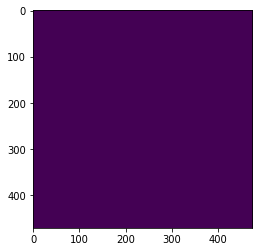

In [ ]:
import matplotlib.pyplot as plt
  

  
dataset = gdal.Open(r'/content/drive/MyDrive/ADS_ML_Spring_2022/ADS/Data/Final_Test/staten_4_crop.tif')
# dataset = LCZFile

band1 = dataset.GetRasterBand(1) 
b1 = band1.ReadAsArray()
f = plt.figure()

# img = np.dstack((b1))
plt.imshow(b1)
plt.savefig('Tiff.png')
plt.show()

In [ ]:
np.unique(b1)

array([0], dtype=uint8)